# EDA on processed workout data + anomoly detection
## Feb 20, 2026

In [1]:
import pandas as pd
from pprint import pprint
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib
import numpy as np

def thousands(x, pos):
    return f'{x*1e-3:.0f}k' if x >= 1000 else int(x)

# Load the data

In [17]:
df = pd.read_csv("data/processed_activities.csv")
df['start_date'] = pd.to_datetime(df['start_date'])
print(df.shape)
print(df.columns)

(398442, 33)
Index(['id', 'user_id', 'sport_type', 'sport_type_grouped', 'distance',
       'miles', 'kilometers', 'moving_time', 'elapsed_time', 'moving_minutes',
       'elapsed_minutes', 'moving_time_per', 'total_elevation_gain',
       'meters_per_km', 'feet_per_mile', 'commute', 'manual', 'has_gear',
       'suffer_score', 'kudos_count', 'device_name', 'start_date', 'hour',
       'day_part', 'month', 'dayofweek', 'is_weekend',
       'is_northern_hemisphere', 'num_turns', 'turns_per_mile', 'wobble',
       'sprawl', 'speed_mph'],
      dtype='object')


# Data Dictionary

- id - unique ID for workout
- user_id - unique ID for athlete who did the workout
- sport_type - sport for the workout (~40 unique)
- sport_type_grouped - groups workouts into main groups
- speed_mph - miles / elapsed time in hours
- distance - distance in meters
- miles - distance in miles
- kilometers - distance in kilometers
- moving_time - seconds of active moving time (pauses for red light, water break, etc)
- elapsed_time - total seconds for entire workout
- moving_minutes - minutes of active moving time
- elapsed_minutes - minutes for entire workout
- moving_time_per - moving_minutes / elapsed_minutes
- total_elevation_gain - meters of climbing
- meters_per_km - avg meters of climbing per kilometer
- feet_per_mile - avg feet of climbing per mile (for the Americans lol)
- commute - boolean flag is user marked the activity as a commute (like when Oliver bikes to class)
- manual - flag for if the workout was generated by a tracking device or if user manually entered the details
- has_gear - boolean for if user indicated which shoes/bike they used for the workout
- suffer_score - Strava metric used to describe how tough the workout is; function of heart rate and total time
- kudos_count - how many "likes" the workout received on Strava
- device_name - name used to record the workout
- start_date - date of workout
- hour - hour of workout (start)
- day_part - morning vs afternoon vs evening vs night (start)
- month - month of workout
- dayofweek - day of week of workout
- is_weekend - boolean for if dayofweek == Saturday or Sunday
- is_northern_hemisphere - start_lat > 0
- num_turns - number of turns in the GPS trace
- turns_per_mile - num_turns / miles
- wobble - how wiggly vs straight the trace is (ignoring turns)
- sprawl - distance (in miles) from most northwest vs most southeast points in the trace

# Inspect column values 

In [3]:
assert(df['id'].isna().sum() == 0) # confirm no missing workout IDs
assert(df['id'].duplicated().sum() == 0) # confirm no duplicate workout IDs

In [4]:
# what percentage of values are missing from each column?
pd.DataFrame(((len(df) - df.count()) / len(df)).sort_values())

,0
id,0.000000
is_northern_hemisphere,0.000000
is_weekend,0.000000
dayofweek,0.000000
month,0.000000
day_part,0.000000
hour,0.000000
start_date,0.000000
kudos_count,0.000000
has_gear,0.000000


- We will likely want to drop suffer_score and device_name.
- The 14% missing values in wobble, num_turns, turns_per_mile, and sprawl are totally valid - these rows just represent workouts recorded without GPS (like weight lifting or tennis)

### value==0 counts
Strava fills in some missing values with 0s

In [8]:
# what percentage of values are 0 for each column?
pd.DataFrame(((df == 0).sum() / len(df) * 100).sort_values())

,0
id,0.000000
user_id,0.000000
sport_type,0.000000
sport_type_grouped,0.000000
month,0.000000
day_part,0.000000
start_date,0.000000
device_name,0.000000
sprawl,0.001255
moving_time_per,0.013051


- Manual and commute likely going to be unhelpful metrics. Although it's good that so few workouts are manual entries.

### Value counts

In [9]:
print(f"Data come from {len(df['user_id'].unique())} total athletes")
print(f"Does an average of ~{round(len(df) / len(df['user_id'].unique()))} activities per athlete pass a sanity check?")

print("\nYes, that is a reasonable number, but there is a large spread.")
print("\n\nUsers with the most activities:")
display(df['user_id'].value_counts().head(3))
print("\nUsers with the least activities:")
display(df['user_id'].value_counts().tail(3))

Data come from 347 total athletes
Does an average of ~1148 activities per athlete pass a sanity check?

Yes, that is a reasonable number, but there is a large spread.


Users with the most activities:


user_id
123    6673
58     6361
7      6042
Name: count, dtype: int64


Users with the least activities:


user_id
101    2
50     2
303    1
Name: count, dtype: int64

In [10]:
print(f"There are {len(df['sport_type'].unique())} unique sport types in the data\n")

ridesRunsWalks = df[(df['sport_type'] == 'Ride') | (df['sport_type'] == 'Run') | (df['sport_type'] == 'Walk')]

print(f"Yet {round(len(ridesRunsWalks) / len(df) * 100, 2)}% of all activities come from just three sports: rides, runs, walks")

display(pd.DataFrame(df['sport_type'].value_counts() / len(df)).head(10))

print("Hence why sport_type_grouped is useful:")

# 41.5% of activities are rides, 33.8% are runs, 16.6% are walks, and 8% are work outs
display(pd.DataFrame(df['sport_type_grouped'].value_counts() / len(df)).head(10))

There are 50 unique sport types in the data

Yet 81.9% of all activities come from just three sports: rides, runs, walks


,count
sport_type,
Ride,0.369431
Run,0.358223
Walk,0.091331
Hike,0.028867
Workout,0.023424
VirtualRide,0.020899
WeightTraining,0.017779
Swim,0.016805
MountainBikeRide,0.012441


Hence why sport_type_grouped is useful:


,count
sport_type_grouped,
Ride,0.420508
Run,0.365629
Workout,0.093329
Walk,0.091665
Hike,0.028867


In [11]:
print(df[['num_turns', 'turns_per_mile', 'wobble', 'sprawl']].describe())

           num_turns  turns_per_mile         wobble         sprawl
count  342860.000000   342860.000000  342860.000000  342860.000000
mean        9.073986        1.763062      42.759043       4.497730
std         6.875100        2.330017      41.817661      16.013925
min         0.000000        0.000000       0.000000       0.000000
25%         4.000000        0.422819      12.655162       1.007777
50%         8.000000        1.111666      33.037247       2.056548
75%        13.000000        2.294017      59.873295       4.772752
max        61.000000      183.921955     874.769482    7257.460001


- Some of the max values are unreasonable. We will have to do a lot of work in anomaly detection (DBSCAN). Some users annoyingly uploaded jet ski rides, plane trips, helicopter rides, car drives, etc.

# Hour, day, month of activities

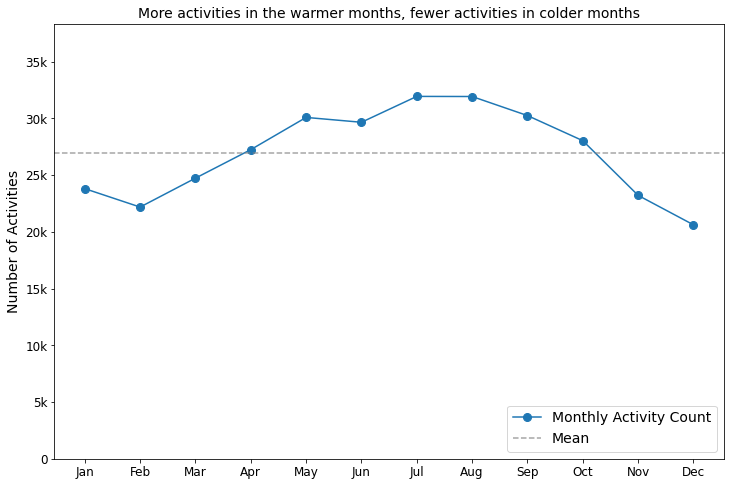

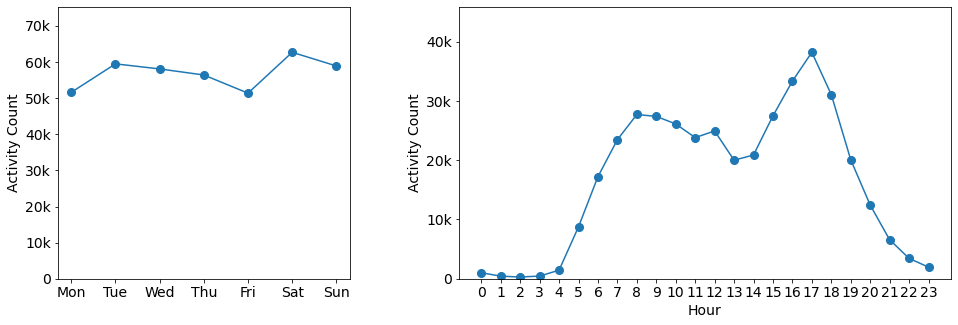

In [14]:
# Compute monthly activity counts (subsetting from northern hemisphere)
values = df[df['is_northern_hemisphere'] == 1]['month'].value_counts().sort_index()

# Create a single plot
plt.figure(figsize=(12, 8))
plt.plot(list(calendar.month_abbr)[1:], values, 'o-', markersize = 8, label='Monthly Activity Count')

# Add mean line
plt.axhline(values.mean(), linestyle = '--', color = 'gray', label = "Mean", alpha = 0.7)

# Formatting
plt.ylim(bottom=0, top = values.max() * 1.2)
plt.ylabel('Number of Activities', fontsize = 14)
plt.title('More activities in the warmer months, fewer activities in colder months', fontsize = 14)
plt.legend(loc='lower right', fontsize = 14)

plt.tick_params(labelsize = 12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands))

plt.show()

# day
fig = plt.figure(figsize=(16, 5))
gs = matplotlib.gridspec.GridSpec(1, 5, figure=fig, wspace=1.2)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])

day_values = df['dayofweek'].value_counts().sort_index()
ax1.plot(calendar.day_abbr, day_values, 'o-', markersize=8)
ax1.set_ylim(bottom=0, top=day_values.max() * 1.2)
ax1.set_ylabel('Activity Count', fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(thousands))

# hour
hour_values = df['hour'].value_counts().sort_index()
ax2.plot(hour_values, 'o-', markersize=8)
ax2.set_ylim(bottom=0, top=hour_values.max() * 1.2)
ax2.set_xticks(np.arange(24))
ax2.set_xlabel('Hour', fontsize=14)
ax2.set_ylabel('Activity Count', fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.set_major_formatter(FuncFormatter(thousands))

plt.show()

# Saturdays and Sundays are the most active days - weekend warriors rejoice!
# Mondays and Fridays are the most popular rest days, which any runner/cyclist already knew

# hour distribution makes sense too

# Speed distribution

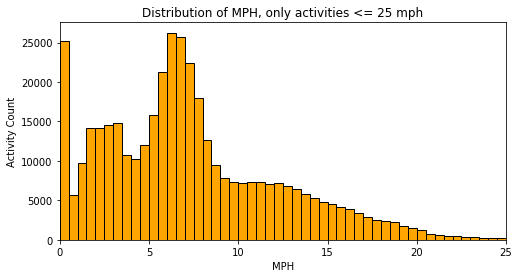

In [20]:
threshold = 25

plt.figure(figsize=(8, 4))
plt.hist(df[df['speed_mph'] <= threshold]['speed_mph'], bins=50, color='orange', edgecolor='black')
plt.xlabel('MPH')
plt.ylabel('Activity Count')
plt.title(f'Distribution of MPH, only activities <= {threshold} mph')
plt.xlim(0, threshold)
plt.show()

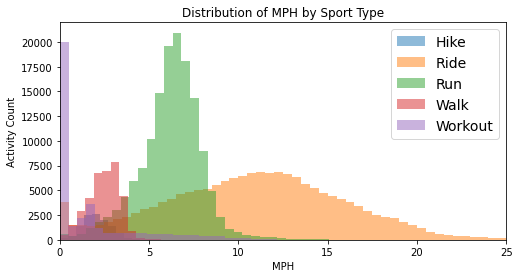

In [21]:
plt.figure(figsize=(8, 4))

for sport, group in df[df['speed_mph'] <= threshold].groupby('sport_type_grouped'):
    plt.hist(
        group['speed_mph'], 
        bins=50, 
        alpha=0.5,
        label=sport, 
        #edgecolor='black'
    )

plt.xlabel('MPH')
plt.ylabel('Activity Count')
plt.title(f'Distribution of MPH by Sport Type')
plt.xlim(0, threshold)
plt.legend(fontsize=14)
plt.show()

- speed is showing great separation between the sports! Of course hikes are completely overlapped in the walk bins (although avg hike def looks slower than avg walk). Ride has such a wide distribution compared to Runs, Walks, and Hikes.

# Data quality checks and anomoly detection
## flag suspect data

There are going to be a ton of workouts that are so clearly off:
- the GPS completely glitched
- a human error occured (forgot to turn watch off at the end of a workout)
- someone uploaded a non-workout to Strava (plane rides, helicopter rides, jet ski rides, etc)

These are all observations we will want to detect and flag as a non-ride, non-run, non-walk, non-hike, non-workout, etc

In [66]:
# list of preview columns to help understand weird observations
columns = ['id', 'sport_type', 'miles', 'elapsed_time', 'speed_mph', 'start_date', 'feet_per_mile']

# flag to track problem rows
df['bad_data'] = 0

## Some quick and easy wins

In [33]:
# start date
# 1969-12-31 is almost certaintly unix timestamp zero
# I'm also skeptical of the 1990 activity
# flag activities prior to 1999 - the year GPS watches hit the market
df.loc[(df['start_date'].dt.year < 1999)][columns]

,id,sport_type,miles,elapsed_time,speed_mph,start_date
10576,10582,Run,3.421815,1863,6.612202,1970-01-03 11:39:25
22663,22681,Swim,0.699192,2206,1.141021,1990-01-22 09:02:10
204395,204900,Ride,67.969546,0,0.000000,1970-01-01 03:00:01
204876,205381,Workout,0.000000,674,0.000000,1969-12-31 18:00:00
204949,205454,Yoga,0.000000,1055,0.000000,1969-12-31 17:00:00
274835,275519,Workout,127.601616,0,0.000000,1970-01-01 03:00:01


## Speed check
By definition, activites with extreme distance values are expected: runners and cyclists spend months doing several shorter training activities to prepare for one long race. 

A more robust data quality check would be a distance:elapsed_time ratio (AKA speed). 

Note that cycling and running have very different 'reasonable' max speeds. Fortunately, any faulty data will likely have speed comparable to a rocket, so the differences in relative running vs cycling speed are likely irrelevant in flagging bad data.

Interesting: in sports, we often assume unrealistic speed means cheating (Strava has competition and leaderboards, and 'athletes' do upload some dumb and unrealistic activities to see their internet points go up). However, in this case, one user (ID 16760381) is simply manually adding activities (as opposed to using a GPS device) and not bothering to add time values. Perhaps the default value is 1? Either way, manual activities are obviously less reliable than otherwise. The distance values are all reasonable, however. For now, let's replace all elapsed_time == 1 with 0 and recompute speed.

- Still catching some activities that's fine but just containing user-error (10.4 miles but in 30 seconds)
- But also now we're seeing some bad GPS data
- Or cases where the GPS is fine but the user annoyingly recorded a plane ride, jet ski, car ride, etc...

In [35]:
threshold = 30 # most e-bikes max out at 28mph

print(f"{len(df[df['speed_mph'] > threshold])} really fast activities")
df.loc[(df['speed_mph'] > threshold)][columns]

553 really fast activities


,id,sport_type,miles,elapsed_time,speed_mph,start_date
1479,1482,Ride,11.133623,1228,32.639287,2013-03-13 19:42:11
1488,1491,Ride,11.094469,1262,31.648246,2013-03-16 10:02:23
1507,1510,Ride,10.852331,1266,30.859708,2013-03-19 20:16:25
1527,1530,Ride,11.203667,1330,30.325715,2013-03-24 21:33:24
7023,7028,Ride,35.904288,3600,35.904288,2013-07-07 22:00:00
...,...,...,...,...,...,...
395083,396276,Ride,60.468055,7200,30.234027,2026-01-31 12:25:27
395338,396532,Ride,0.425730,1,1532.628962,2026-01-02 16:00:00
395339,396533,Ride,2.382225,1,8576.009944,2026-01-30 07:00:00
396691,397890,Ride,4.008701,1,14431.323804,2026-02-05 07:00:00


## Elevation gain data quality check

Elevation gain can erroneously rocket if someone is running through a narrow canyon or along a ridge, and the GPS gets confused and keeps bouncing them up-and-down the terrain. 

In [40]:
# look for workouts in the top x percentile (since Strava data columns all tend ot be long-tailed on the right-side)

percentiles = df['feet_per_mile'].quantile([0.50, 0.90, 0.95, 0.99])
print(percentiles)

threshold = df['feet_per_mile'].quantile(0.99)

# actually some of these are potentially fine
df.loc[df['feet_per_mile'] > threshold][columns]

0.50     31.830853
0.90    111.532405
0.95    161.942265
0.99    377.103155
Name: feet_per_mile, dtype: float64


,id,sport_type,miles,elapsed_time,speed_mph,start_date,feet_per_mile
1464,1467,Run,1.153201,1537,2.701056,2013-03-10 18:05:25,395.453057
2264,2267,Ride,4.446302,18546,0.863080,2013-07-02 12:07:37,557.837729
2265,2268,Ride,1.619018,9731,0.598958,2013-07-01 14:25:33,2105.469309
2303,2306,Hike,4.497887,8791,1.841928,2013-07-13 09:35:21,634.301959
3112,3115,Hike,5.300559,7046,2.708205,2013-12-18 11:03:03,500.120561
...,...,...,...,...,...,...,...
398034,399236,AlpineSki,21.680547,14773,5.283285,2026-02-16 09:40:36,527.993085
398097,399299,Hike,8.119204,17015,1.717845,2026-02-17 10:07:26,419.843197
398149,399352,Run,1.219204,1170,3.751398,2026-02-17 20:35:07,388.037559
398357,399562,Run,2.000435,1338,5.382336,2026-02-19 16:20:00,749.836915


# To-Do
## Anomoly detection (DBSCAN)
## Create a new column to flag sketchy data - in addition to predicting sport_type on unlabeled workout data, the model will need to learn what workouts are clearly not human-powered and should be flagged
## Export data for use in `03-modeling.ipynb`

In [ ]:
# df.to_csv("data/data_for_modeling.csv", index=False)